In [1]:
import datetime
import os 
import shutil
import sys

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# sys.path.append(os.path.join("..", "code"))
# from cnn_model import *
# from tif_files import TifFile, TifDir
# from utils import get_y_data, open_y_data, sat_img_filelist_df

In [2]:
import keras_nlp

# Create Dummy Image Data

In [3]:
observation_period = 30
image_size_x = 10
image_size_y = 10

In [4]:
dummpy_input = np.random.random(size = (observation_period,image_size_x,image_size_y))
dummpy_label = np.random.random(size = observation_period)

In [24]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :],dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = causal_mask # add missing else condition. Use causal mask when mask is not given
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)
    
    

In [26]:
inputs_1 = keras.Input(shape=(observation_period, None, None, 1), batch_size=None, name="img_seq1")
conv_2d_layer_1 = layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), activation='relu')
x_1 = layers.TimeDistributed(conv_2d_layer_1, name="conv2d1")(inputs_1)
pooling_layer_1 = layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)
outputs_1 = layers.TimeDistributed(pooling_layer_1, name="global_pooling1")(x_1)


inputs_2 = keras.Input(shape=(observation_period, None, None, 1), batch_size=None, name="img_seq2")
conv_2d_layer_2 = layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), activation='relu')
x_2 = layers.TimeDistributed(conv_2d_layer_2, name="conv2d2")(inputs_2)
pooling_layer_2 = layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)
outputs_2 = layers.TimeDistributed(pooling_layer_2, name="global_pooling2")(x_2)

concatted = tf.keras.layers.Concatenate(axis = 1)([outputs_1, outputs_2])


# encoder_inputs = keras.Input(shape=(None,None,None), dtype="float64", name="multi_time_series")
# x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim = 16, dense_dim = 32, num_heads = 2)(concatted)

# decoder_inputs = keras.Input(shape=(None,None, None), dtype="float64", name="14-day-prediction")
# x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim = 16, dense_dim = 32, num_heads = 2)(concatted, encoder_outputs)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
decoder_outputs = layers.Dense(14, activation="linear")(x)



transformer = keras.Model([inputs_1, inputs_2], decoder_outputs)

transformer.summary()



# encoder = keras_nlp.layers.TransformerEncoder(
#     intermediate_dim=64, num_heads=8)
# outputs = TransformerEncoder(embed_dim=16, dense_dim=32, num_heads=2)(concatted)
# outputs = TransformerDecoder(embed_dim=16, dense_dim=32, num_heads=2)(outputs)
# outputs = layers.Dense(1, activation="linear")(outputs)
# # outputs = layers.Dense(14, activation="linear")(outputs)
# # outputs = layers.Dense(1, activation="linear")(outputs)

# model = keras.Model(inputs= [inputs_1, inputs_2], outputs=outputs)

# model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_seq1 (InputLayer)          [(None, 30, None, N  0           []                               
                                one, 1)]                                                          
                                                                                                  
 img_seq2 (InputLayer)          [(None, 30, None, N  0           []                               
                                one, 1)]                                                          
                                                                                                  
 conv2d1 (TimeDistributed)      (None, 30, None, No  80          ['img_seq1[0][0]']               
                                ne, 16)                                                     

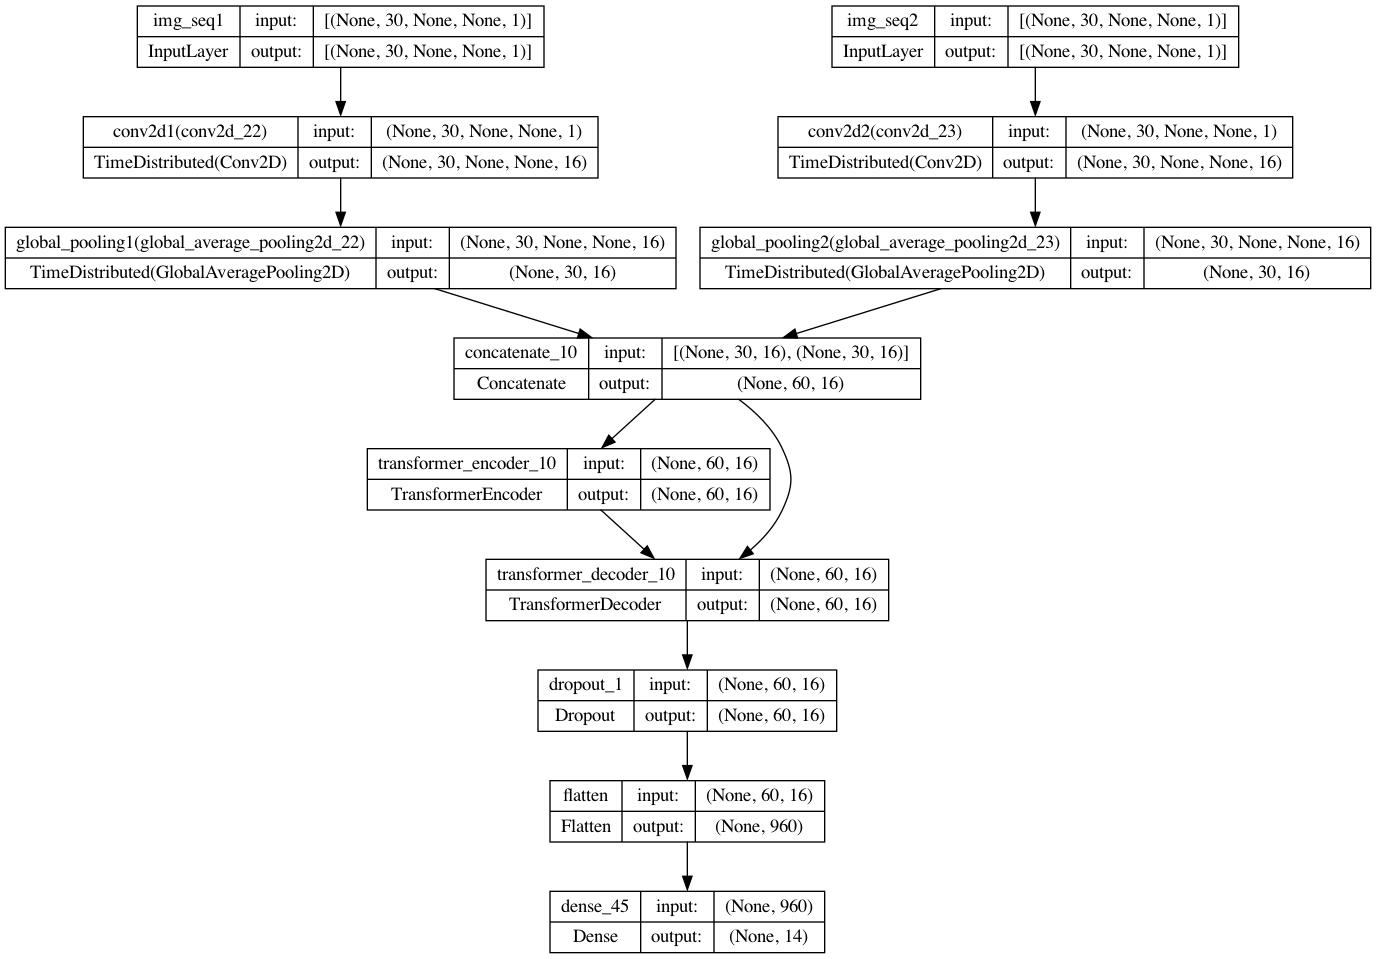

In [28]:
keras.utils.plot_model(transformer, "seq2seq.png", show_shapes=True)

# using keras_nlp (ignore blow for now)

In [34]:
inputs_1 = keras.Input(shape=(observation_period, None, None, 1), batch_size=None, name="img_seq1")
conv_2d_layer_1 = layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), activation='relu')
x_1 = layers.TimeDistributed(conv_2d_layer_1, name="conv2d1")(inputs_1)
pooling_layer_1 = layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)
outputs_1 = layers.TimeDistributed(pooling_layer_1, name="global_pooling1")(x_1)


inputs_2 = keras.Input(shape=(observation_period, None, None, 1), batch_size=None, name="img_seq2")
conv_2d_layer_2 = layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), activation='relu')
x_2 = layers.TimeDistributed(conv_2d_layer_2, name="conv2d2")(inputs_2)
pooling_layer_2 = layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)
outputs_2 = layers.TimeDistributed(pooling_layer_2, name="global_pooling2")(x_2)

concatted = tf.keras.layers.Concatenate(axis = 1)([outputs_1, outputs_2])
encoder = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=16, num_heads=2)(concatted)

#output = decoder(decoder_input, encoder_input)
# outputs = TransformerEncoder(embed_dim=16, dense_dim=32, num_heads=2)(concatted)

# outputs = layers.Dense(1, activation="linear")(outputs)
# outputs = layers.Dense(14, activation="linear")(outputs)
# outputs = layers.Dense(1, activation="linear")(outputs)


# model = keras.Model(inputs= [inputs_1, inputs_2], outputs=encoder)


decoder = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=14, num_heads=2)(encoder)

# Create a simple model containing the decoder.
# decoder_input = keras.Input(shape=[10, 64])
# encoder_input = keras.Input(shape=[10, 64])
# output = decoder(decoder_input, encoder_input)
# model = keras.Model(inputs=[decoder_input, encoder_input],
#     outputs=output)

model = keras.Model(inputs= [inputs_1, inputs_2], outputs=decoder)

model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_seq1 (InputLayer)          [(None, 30, None, N  0           []                               
                                one, 1)]                                                          
                                                                                                  
 img_seq2 (InputLayer)          [(None, 30, None, N  0           []                               
                                one, 1)]                                                          
                                                                                                  
 conv2d1 (TimeDistributed)      (None, 30, None, No  80          ['img_seq1[0][0]']               
                                ne, 16)                                                    